# ***SARIMA vs PROPHET for stock market data***

In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.4 MB/s eta 0:00:00


# **SARIMA MODEL**

Importing the required libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse


import yfinance as yahooFinance

Fetching the Data: Historical Stock prices of Invesco QQQ from Yahoo Finance, between March 2020 and August 2024.



*   Frequency : Daily Data
*   Features : Open, High, Low, Close, Volume, Dividends, Stock Splits, Capital Gains
*   Analyzed feature : ‘Close’ (Closing value of the day)






In [3]:
# startDate , as per our convenience we can modify
startDate = datetime(2020, 3, 1)
endDate = datetime(2024, 8, 1)

GetsnpInformation = yahooFinance.Ticker("QQQ")

# pass the parameters as the taken dates for start and end
df = GetsnpInformation.history(start=startDate, end= endDate)

# data = pd.read_csv('/content/drive/MyDrive/Time Series data/AirPassengers.csv')
#Test = pd.read_csv('/content/drive/MyDrive/Time Series data/2007_flights.csv')
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2024-07-25 00:00:00-04:00,463.720001,467.940002,455.630005,458.269989,59256800,0.0,0.0,0.0
2024-07-26 00:00:00-04:00,462.649994,465.929993,459.769989,462.970001,39992100,0.0,0.0,0.0
2024-07-29 00:00:00-04:00,465.709991,467.910004,461.619995,463.899994,28218500,0.0,0.0,0.0
2024-07-30 00:00:00-04:00,465.850006,466.559998,454.149994,457.529999,41317200,0.0,0.0,0.0
2024-07-31 00:00:00-04:00,467.869995,472.790009,466.410004,471.070007,44552100,0.0,0.0,0.0


Set Frequency :  As we have missing dates for weekends and holiday we have to set a frequency for SARIMA to understand data is daily


In [4]:
df = df.asfreq('D')

In [5]:
data = df ['Close']
#data.index = pd.data.index.to_period('D')

#data = data.asfreq('D')
data

,Close
Date,
2020-03-02 00:00:00-05:00,210.524109
2020-03-03 00:00:00-05:00,203.773148
2020-03-04 00:00:00-05:00,212.275055
2020-03-05 00:00:00-05:00,205.825684
2020-03-06 00:00:00-05:00,202.352936
...,...
2024-07-27 00:00:00-04:00,NaN
2024-07-28 00:00:00-04:00,NaN
2024-07-29 00:00:00-04:00,463.899994


Handling NaNs: For the QQQ dataset, stock market data rarely has missing values I used  forward filling (.ffill()) to fill gaps.

In [6]:
data.fillna(method='ffill', inplace=True)

In [7]:
#Checking data info and summary
data.info()
data.describe()


<class 'pandas.core.series.Series'>
DatetimeIndex: 1613 entries, 2020-03-02 00:00:00-05:00 to 2024-07-31 00:00:00-04:00
Freq: D
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
1613 non-null   float64
dtypes: float64(1)
memory usage: 25.2 KB


,Close
count,1613.000000
mean,331.227196
std,65.387469
min,164.687775
25%,285.302948
50%,325.802765
75%,370.026428
max,502.959991


Analyzing the data in real time. Initial observation:


*   Initial plots show an upward trend in the stock prices
*   Missing dates : Weekends and market holidays
*   The seasonal trends may become clearer after breaking down the time series data.





<Axes: xlabel='Date'>

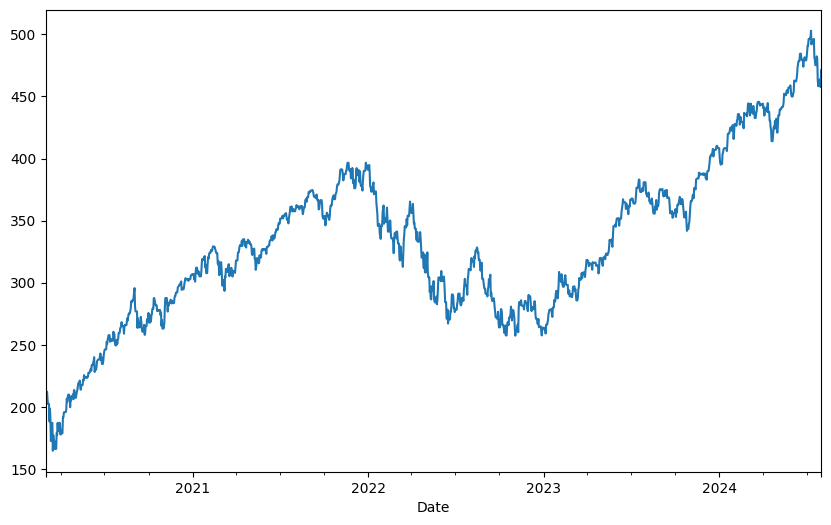

In [8]:
data.plot(figsize=(10, 6))

Seasonal Decomposition: Using seasonal_decompose(), the trend, seasonality, and residuals are extracted, and the plots reveal how the data behaves over time.


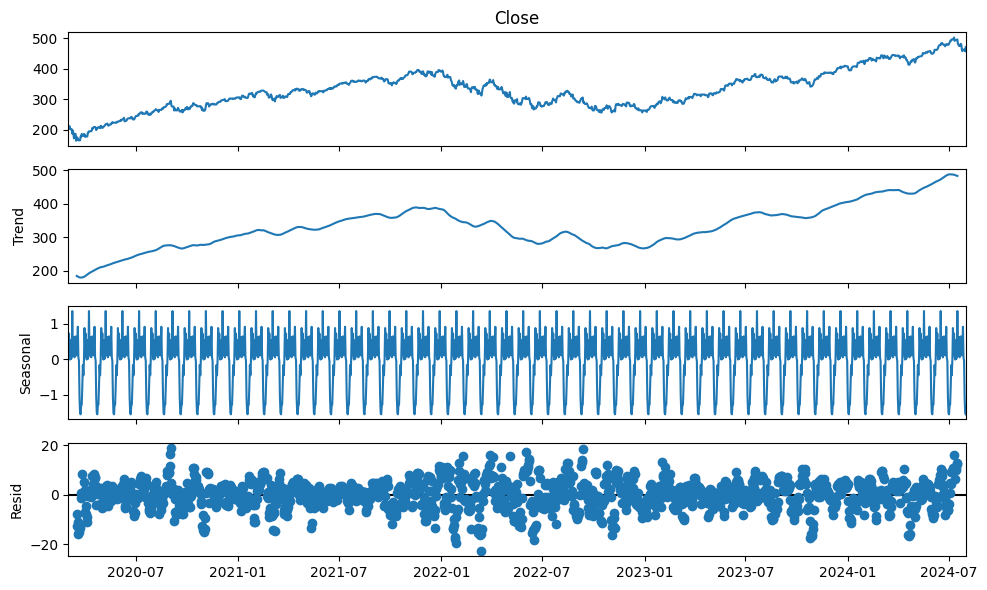

In [9]:
#data.index = data.index.to_timestamp()
result_monthly = seasonal_decompose(data, model="additive", period = 30)

trend = result_monthly.trend
seasonal = result_monthly.seasonal
residual = result_monthly.resid


plt.rcParams["figure.figsize"] = (10, 6)
fig = result_monthly.plot()

Stationarity Check: The Augmented Dickey-Fuller (ADF) test is applied twice:

*   Before transformation: Non-stationary data (P-value > 0.05).
*   If the p-value is higher than 0.05, the series is non-stationary, indicating the need for transformation (e.g., differencing or log transformation).







In [10]:

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(data)

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.5493272981915445
2. P-Value :  0.5089842019819991
3. Num Of Lags :  14
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1598
5. Critical Values :
	 1% :  -3.4344487706424953
	 5% :  -2.8633503662338877
	 10% :  -2.567733803393165


Dividing the data into Training and Testing dataset


In [11]:
train_data = data[:len(data)-7]
test_data = data[len(data)-7:]
train_data, test_data


(Date
 2020-03-02 00:00:00-05:00    210.524109
 2020-03-03 00:00:00-05:00    203.773148
 2020-03-04 00:00:00-05:00    212.275055
 2020-03-05 00:00:00-05:00    205.825684
 2020-03-06 00:00:00-05:00    202.352936
                                 ...    
 2024-07-20 00:00:00-04:00    475.239990
 2024-07-21 00:00:00-04:00    475.239990
 2024-07-22 00:00:00-04:00    482.320007
 2024-07-23 00:00:00-04:00    480.619995
 2024-07-24 00:00:00-04:00    463.380005
 Freq: D, Name: Close, Length: 1606, dtype: float64,
 Date
 2024-07-25 00:00:00-04:00    458.269989
 2024-07-26 00:00:00-04:00    462.970001
 2024-07-27 00:00:00-04:00    462.970001
 2024-07-28 00:00:00-04:00    462.970001
 2024-07-29 00:00:00-04:00    463.899994
 2024-07-30 00:00:00-04:00    457.529999
 2024-07-31 00:00:00-04:00    471.070007
 Freq: D, Name: Close, dtype: float64)

Log Transformation: The data was log-transformed (logged_closevalues), which smooths out large swings, making the time series more stationary for modeling.

<Axes: title={'center': 'Original Values'}, xlabel='Date'>

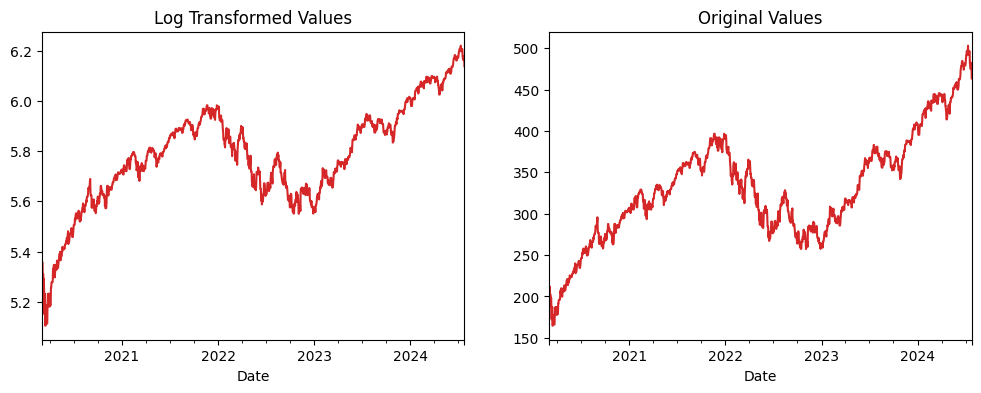

In [12]:
logged_closevalues = train_data.apply(lambda x : np.log(x))
ax1 = plt.subplot(121)
logged_closevalues.plot(figsize=(12,4) ,color="tab:red", title="Log Transformed Values", ax=ax1)
ax2 = plt.subplot(122)
train_data.plot(color="tab:red", title="Original Values", ax=ax2)

After log transformation:

*   Achieves stationarity with a P-value of 0.03, which is below the 0.05 threshold



In [13]:
dftest = adfuller(logged_closevalues)

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.0195924273867822
2. P-Value :  0.03310478378022734
3. Num Of Lags :  20
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1585
5. Critical Values :
	 1% :  -3.4344824429999132
	 5% :  -2.863365228537185
	 10% :  -2.567741717501418


Best Model: The sarima_grid_search() function systematically searches for the best SARIMA model by minimizing the AIC value.


*   After iterating over parameter combinations, a model with an optimal set of parameters (e.g., (1, 0, 1) (1, 0, 0, 30)) is selected.
*   The model is trained on the dataset, and predictions are made for the test data.



In [14]:
import itertools
def sarima_grid_search(dataframe, s):
    p = d = q = range(2)
    param_combinations = list(itertools.product(p, d, q))

    lowest_aic, pdq, pdqs = None, None, None

    total_iterations = 0
    for order in param_combinations:
        for (p, q, d) in param_combinations:
            seasonal_order = (p, q, d, s)
            total_iterations += 1
            try:
                #print('yayyy')
                model = SARIMAX(dataframe, order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                    disp=False
                )
                model_result = model.fit(maxiter=200, disp=False)
                #print(model_result)
                if not lowest_aic or model_result.aic < lowest_aic:
                    lowest_aic = model_result.aic
                    pdq, pdqs = order, seasonal_order
                    print(lowest_aic, pdq, pdqs)

            except Exception as ex:
                continue

    return lowest_aic, pdq, pdqs

In [15]:
lowest_aic, order, seasonal_order = sarima_grid_search(logged_closevalues, 30)

10191.157792256794 (0, 0, 0) (0, 0, 0, 30)
7977.528713676866 (0, 0, 0) (0, 0, 1, 30)
-4153.149751744809 (0, 0, 0) (0, 1, 0, 30)
-4200.385710177845 (0, 0, 0) (0, 1, 1, 30)
-4271.822813677107 (0, 0, 0) (1, 0, 0, 30)
-4275.997418219099 (0, 0, 0) (1, 0, 1, 30)
-4277.438921749214 (0, 0, 0) (1, 1, 1, 30)
-5711.063184073211 (0, 0, 1) (0, 1, 0, 30)
-5755.73111247789 (0, 0, 1) (0, 1, 1, 30)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-5803.475910158821 (0, 0, 1) (1, 0, 0, 30)
-9208.360054510853 (0, 1, 0) (0, 0, 0, 30)
-9394.49888836156 (0, 1, 0) (0, 0, 1, 30)
-9398.430688607734 (0, 1, 0) (1, 0, 0, 30)
-9399.822430697768 (0, 1, 1) (1, 0, 0, 30)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-9400.031736007773 (1, 0, 0) (1, 0, 0, 30)
-9401.83365534767 (1, 0, 1) (1, 0, 0, 30)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA result summary after fitting the SARIMA model on training data

In [16]:
model = SARIMAX(
    logged_closevalues,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
    disp=False
)

model_results = model.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                 1606
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 30)   Log Likelihood                4704.917
Date:                             Mon, 16 Sep 2024   AIC                          -9401.834
Time:                                     15:23:24   BIC                          -9380.386
Sample:                                 03-02-2020   HQIC                         -9393.863
                                      - 07-24-2024                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0001   5.09e-05   1.97e+04      0.000       1.000       1.000
ma.L1         -0.0502      0.022     -2.335      0.020      -0.092      -0.008
ar.S.L30      -0.0076      0.022     -0.345      0.730      -0.051       0.036
sigma2         0.0001   3.28e-06     45.383      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               854.72
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

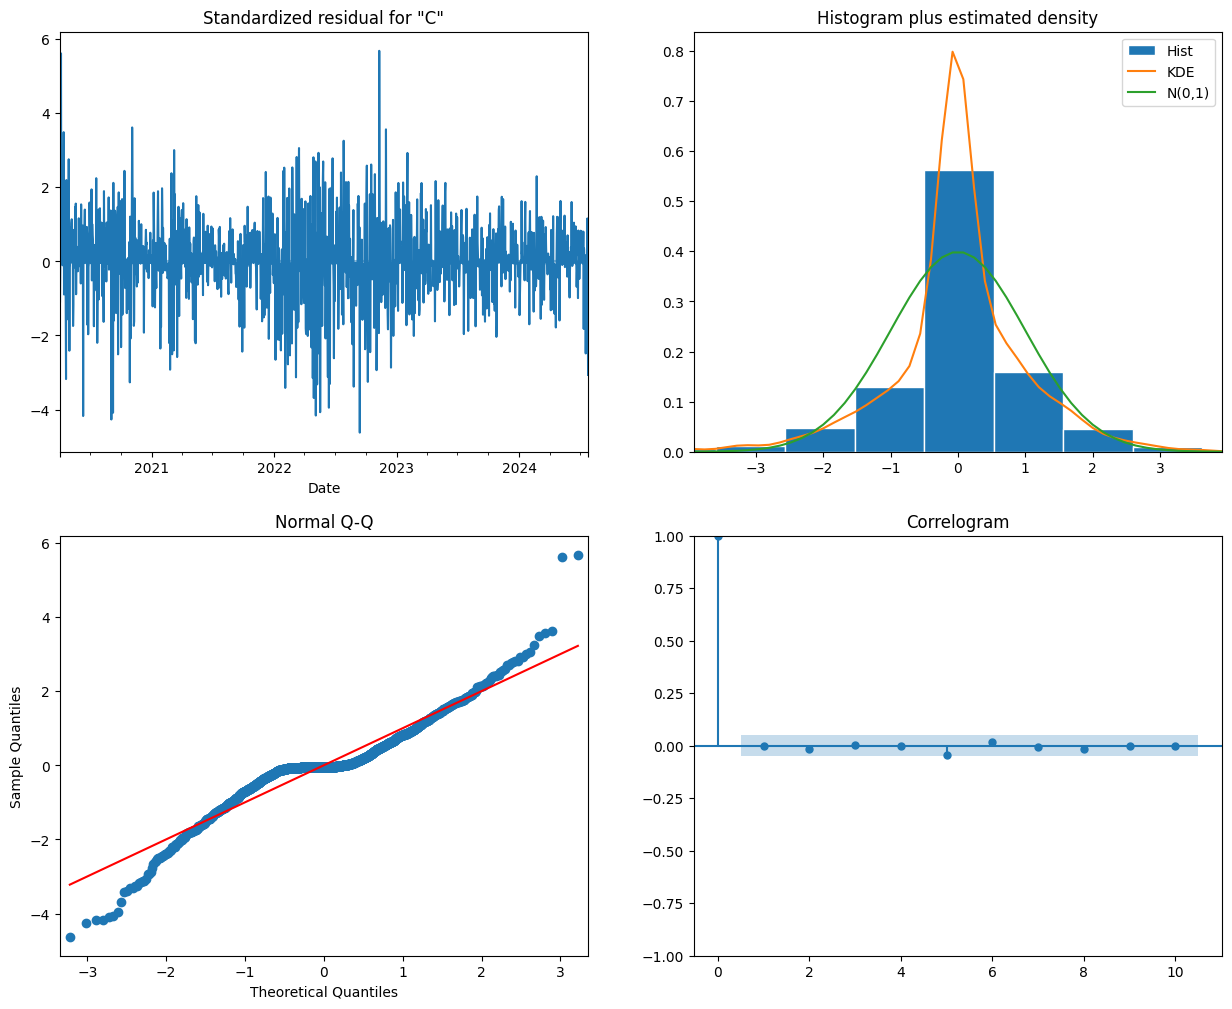

In [17]:
model_results.plot_diagnostics(figsize=(15, 12))
plt.show()


Plotting the actual vs. forecasted values



*   Forecasting period :  7 Days
*   Here, we can see the SARIMA is predicting near to the actual values but threshold bands are still wide




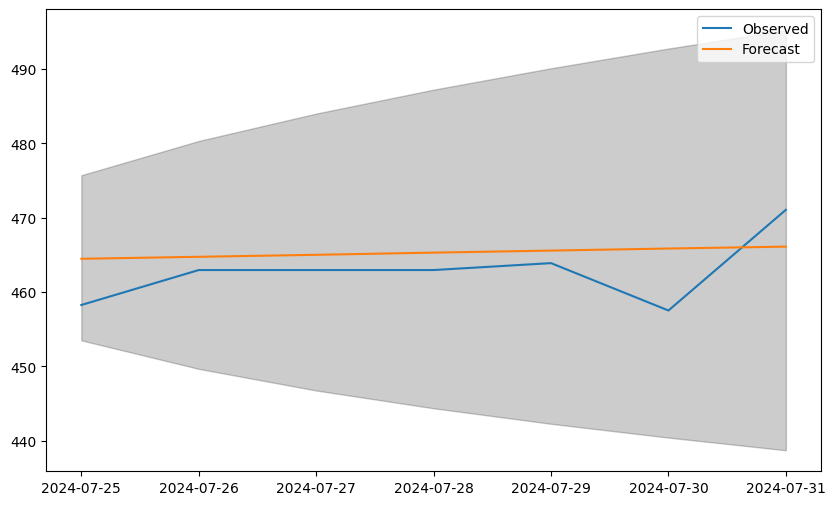

In [18]:
# Forecasting
forecast = model_results.get_forecast(steps=7)
forecast_ci = forecast.conf_int()

# Transform back to original scale
forecast_mean = np.exp(forecast.predicted_mean)
forecast_lower = np.exp(forecast_ci.iloc[:, 0])
forecast_upper = np.exp(forecast_ci.iloc[:, 1])
forecast_mean
# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data, label='Observed')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast')
plt.fill_between(forecast_mean.index, forecast_lower, forecast_upper, color='k', alpha=0.2)
plt.legend()
plt.show()

Below are the RMSE and MSE of SARIMA for 7 days forecast


In [19]:
#test_data = data[-30:]
sarima_pred = model_results.predict(start=len(train_data), end= len(data) - 1, typ="levels").rename("SARIMA Predictions")

sarima_pred_org = np.exp(sarima_pred)
sarima_rmse_error = rmse(test_data, sarima_pred_org)
sarima_mse_error = sarima_rmse_error**2
mean_value = data.mean()
#sarima_pred_org
print(f'MSE Error: {sarima_mse_error}\nRMSE Error: {sarima_rmse_error}\nMean: {mean_value}')

MSE Error: 21.184711339228183
RMSE Error: 4.60268523138702
Mean: 331.22719645396717


Predicted VS Actual closing price

<Axes: xlabel='Date'>

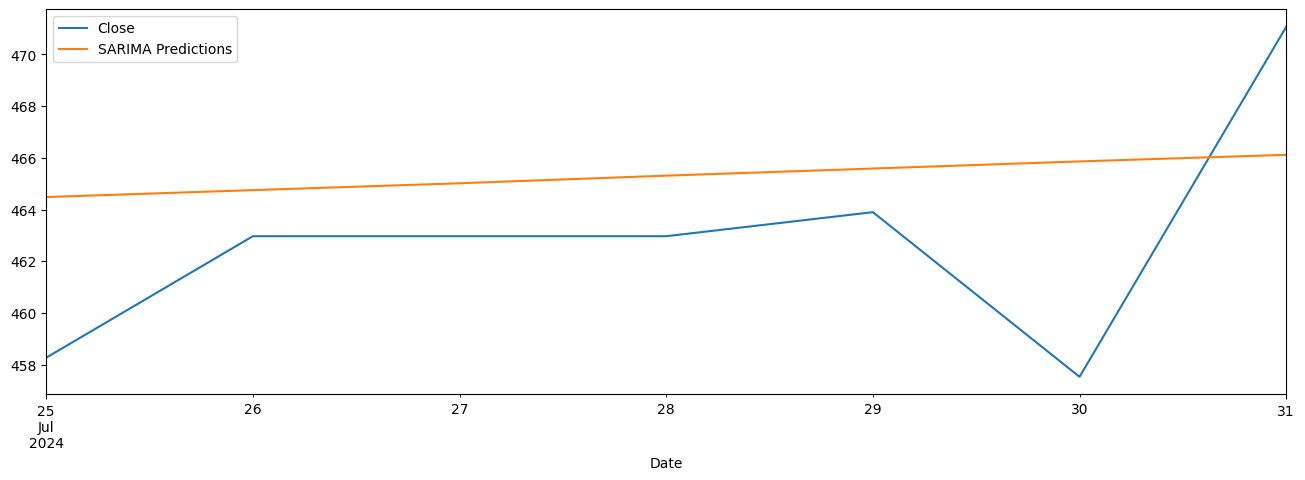

In [20]:
test_data.plot(figsize = (16,5), legend=True)
sarima_pred_org.plot(legend = True)

# **Prophet Model**


Defining the dataset for prophet:


*   The input dataset should have ds and y columns



*   ds column indicates the Date and y column indicates the analysing Feature. In our case Close value






In [31]:
df_pr = df.copy()
df_pr = df_pr['Close']
df_pr = df_pr.reset_index()

df_pr.columns = ['ds','y'] # To use prophet column names should be like that
train_data_pr = df_pr.iloc[:len(df_pr)-7]
test_data_pr = df_pr.iloc[len(df_pr)-7:]

In [32]:
df_pr

,ds,y
0,2020-03-02 00:00:00-05:00,210.524109
1,2020-03-03 00:00:00-05:00,203.773148
2,2020-03-04 00:00:00-05:00,212.275055
3,2020-03-05 00:00:00-05:00,205.825684
4,2020-03-06 00:00:00-05:00,202.352936
...,...,...
1608,2024-07-27 00:00:00-04:00,462.970001
1609,2024-07-28 00:00:00-04:00,462.970001
1610,2024-07-29 00:00:00-04:00,463.899994
1611,2024-07-30 00:00:00-04:00,457.529999


<Axes: xlabel='ds'>

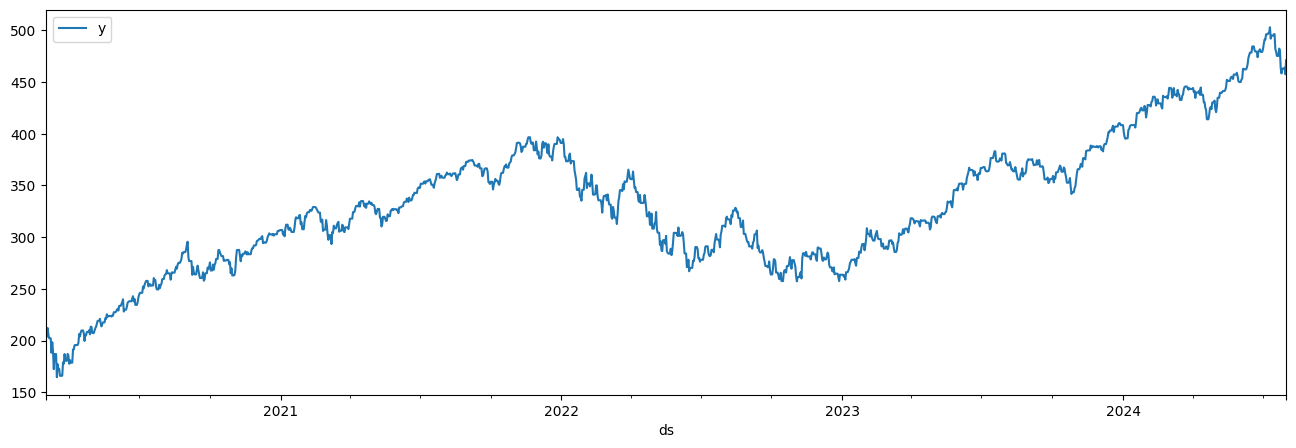

In [33]:
df_pr['ds'] = pd.DatetimeIndex(df_pr['ds'])
df_pr.set_index('ds').plot(figsize = (16,5), legend=True)

Installing the prophet dependency

In [34]:
!pip install prophet

Retriving only date from the datetime stamp

In [35]:
train_data_pr['ds'] = train_data_pr['ds'].dt.date


*   Using fit() method fitting the model on training data

*   Displaying the predictions using "yhat" and thresholds "yhat_lower" and "yhat_upper"



In [36]:
from prophet import Prophet
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=30,freq='D')
prophet_pred = m.predict(future)
prophet_pred[["ds", "yhat_lower", 	"yhat_upper", "yhat"]].tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpufmjub2m/017vdhvf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpufmjub2m/xf80zo25.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45613', 'data', 'file=/tmp/tmpufmjub2m/017vdhvf.json', 'init=/tmp/tmpufmjub2m/xf80zo25.json', 'output', 'file=/tmp/tmpufmjub2m/prophet_modelumdz1yb1/prophet_model-20240916161900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:19:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:19:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat_lower,yhat_upper,yhat
1631,2024-08-19,493.541901,519.041603,505.523166
1632,2024-08-20,493.539653,517.784857,506.051535
1633,2024-08-21,493.227862,518.656522,506.410898
1634,2024-08-22,494.974683,518.998445,506.944778
1635,2024-08-23,494.604237,519.929698,507.328107


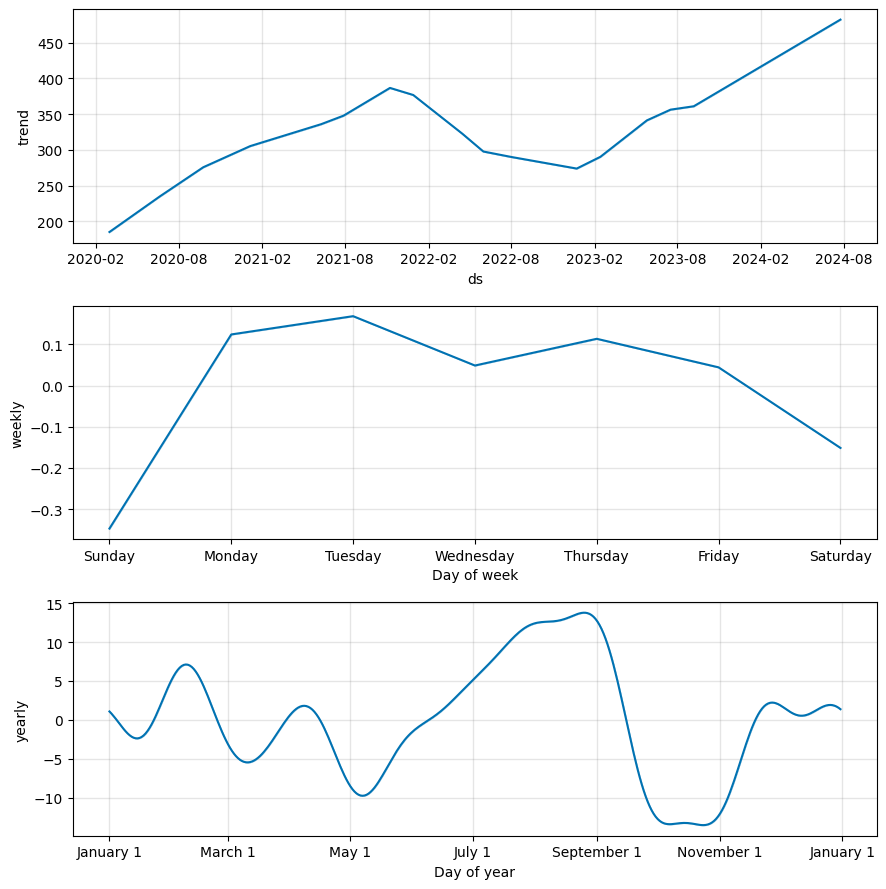

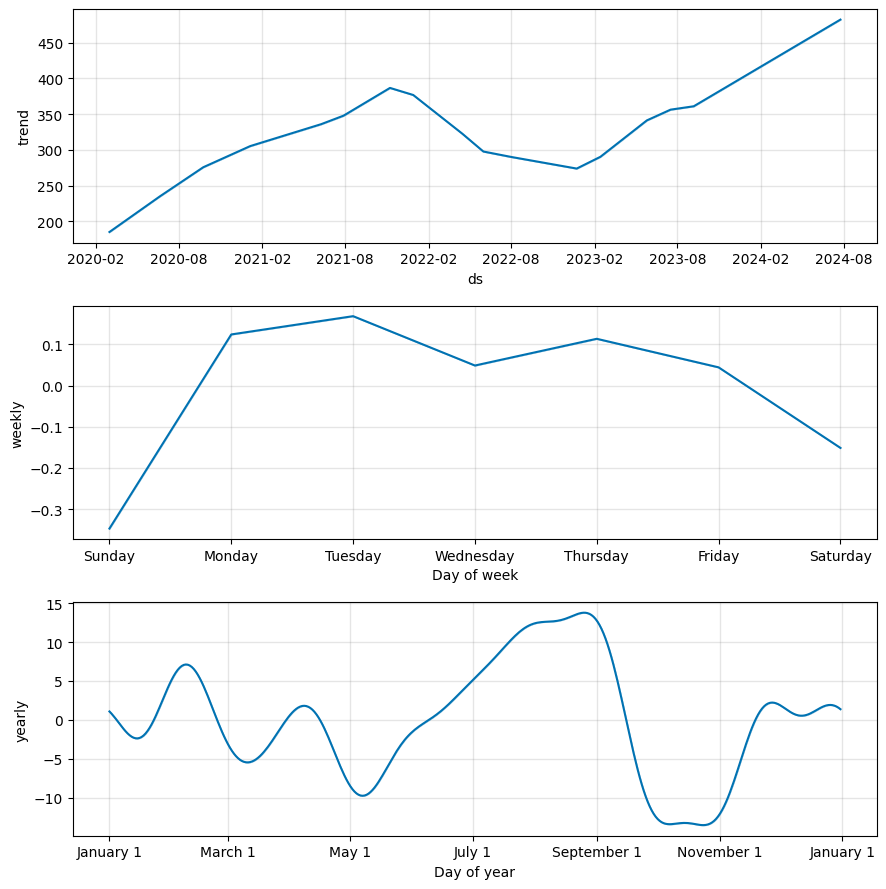

In [37]:
forecast1 = m.predict(train_data_pr)
m.plot_components(forecast1)

In [38]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-7:]['ds'], "Pred" : prophet_pred[-7:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "D"
prophet_pred

,Pred
Date,
2024-08-17,504.283901
2024-08-18,504.567811
2024-08-19,505.523166
2024-08-20,506.051535
2024-08-21,506.410898
2024-08-22,506.944778
2024-08-23,507.328107


<Axes: xlabel='ds'>

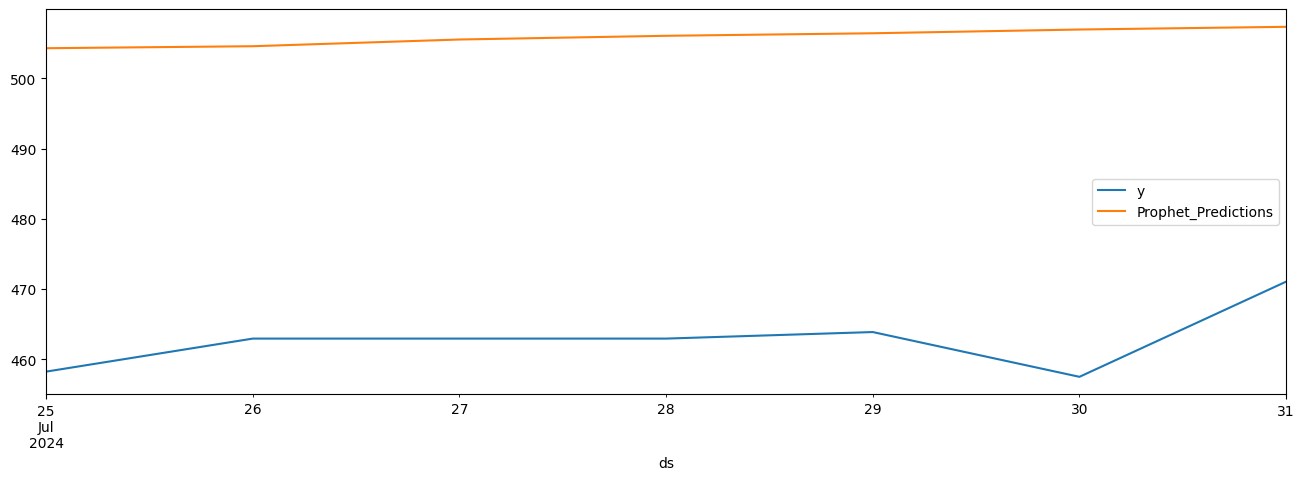

In [41]:
test_data_pr["Prophet_Predictions"] = prophet_pred['Pred'].values
test_data_pr.set_index('ds').plot(figsize = (16,5), legend=True)

Analyzing the errors to evaluate the performance of both models


In [45]:
prophet_rmse_error = rmse(test_data_pr['y'], test_data_pr["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df_pr['y'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 1868.2993556249216
RMSE Error: 43.223828562783766
Mean: 331.22719645396717


Adding the SARIMA predcitions to compare both results

In [42]:
test_data_pr["SARIMA_Predictions"] = sarima_pred_org.values
test_data_pr


,ds,y,Prophet_Predictions,SARIMA_Predictions
1606,2024-07-25 00:00:00-04:00,458.269989,504.283901,464.484846
1607,2024-07-26 00:00:00-04:00,462.970001,504.567811,464.752456
1608,2024-07-27 00:00:00-04:00,462.970001,505.523166,465.018424
1609,2024-07-28 00:00:00-04:00,462.970001,506.051535,465.312118
1610,2024-07-29 00:00:00-04:00,463.899994,506.410898,465.587590
1611,2024-07-30 00:00:00-04:00,457.529999,506.944778,465.863252
1612,2024-07-31 00:00:00-04:00,471.070007,507.328107,466.118366


Comparing the results from both fine tuned SARIMA and Prophet models for the 7 days forecasting


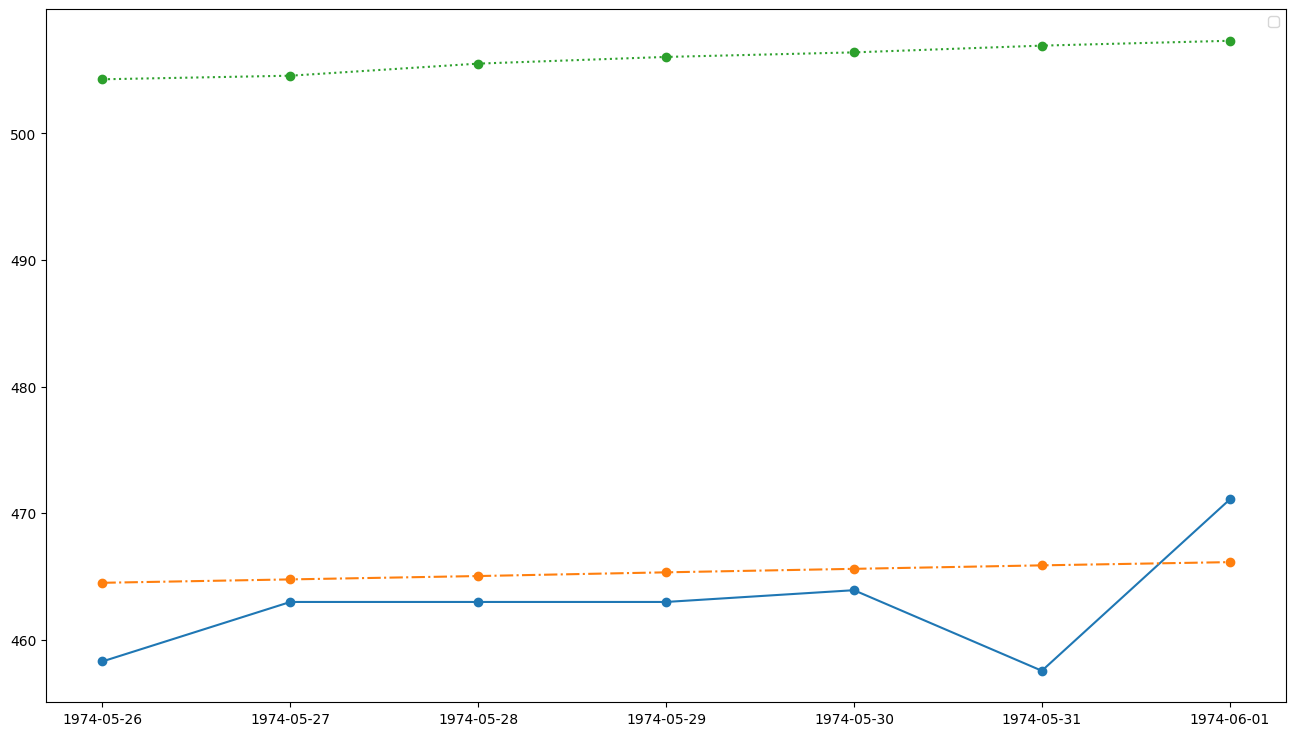

In [46]:
rmse_errors = [sarima_rmse_error, prophet_rmse_error]
mse_errors = [sarima_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})
plt.figure(figsize=(16,9))
plt.plot_date(test_data_pr.index, test_data_pr["y"], linestyle="-")
plt.plot_date(test_data_pr.index, test_data_pr["SARIMA_Predictions"], linestyle="-.")
plt.plot_date(test_data_pr.index, test_data_pr["Prophet_Predictions"], linestyle=":")
plt.legend()
plt.show()

Here, we can clearly see that fine tuned SARIMA model outperforms the Prophet model


In [47]:
errors

,Models,RMSE Errors,MSE Errors
0,ARIMA,4.602685,21.184711
1,Prophet,43.223829,1868.299356


Accuracy: From my analysis, fine tuned SARIMA outperforms Prophet in shifts and seasonality in financial data due to its fine tuning in trend modeling.





*   Advantages:
Prophet: Better at capturing long-term trends and handling irregular patterns (like market holidays or earnings seasons). Suitable for data with non-linear trends and seasonality.
SARIMA: Useful for datasets where seasonality and trends are well-defined and consistent over time. More control over parameters like seasonality and lag.


*   Flexibility:
Prophet: Easier to tune with built-in support for seasonality and holidays.
SARIMA: Requires more manual tuning and experimentation, but offers better interpretability in terms of AR, MA, and seasonal components.
